In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import imageio
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Conv2D, MaxPooling2D,Flatten, Reshape, Dropout, BatchNormalization,LeakyReLU, Conv2DTranspose, ReLU
from matplotlib import pyplot as plt
import numpy as np
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
import random
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
import math
import os
from tensorflow.python.client import device_lib
import time
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [2]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6738213430997960656
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5757075456
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8744874134372957373
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
# useful class and functions
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
class UnconditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(UnconditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(UnconditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        real_images, one_hot_labels = data
        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal([batch_size, self.latent_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_loss_tracker.update_state(disc_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

def build_train_unconditional_gan(latent_dim):
    start_time = time.time()
    generator_in_channels = latent_dim
    discriminator_in_channels = 1
    discriminator = keras.Sequential(
        [
            keras.layers.InputLayer((28, 28, discriminator_in_channels)),
            layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.GlobalMaxPooling2D(),
            layers.Dense(1),
        ],
        name="discriminator",
    )
    # Create the generator.
    generator = keras.Sequential(
        [
            keras.layers.InputLayer((generator_in_channels,)),
            # We want to generate 128 + num_classes coefficients to reshape into a
            # 7x7x(128 + num_classes) map.
            layers.Dense(7 * 7 * generator_in_channels),
            layers.LeakyReLU(alpha=0.2),
            layers.Reshape((7, 7, generator_in_channels)),
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
        ],
        name="generator",
    )
    uncond_gan = UnconditionalGAN(
        discriminator=discriminator, generator=generator, latent_dim=latent_dim
    )
    uncond_gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    )

    uncond_gan.fit(dataset, epochs=20, verbose = 0)
    end_time = time.time()
    print(f'Time for training GAN model: {round(end_time-start_time,2)} seconds')
    return uncond_gan.generator
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }
def build_train_gan(latent_dim):
    start_time = time.time()
    generator_in_channels = latent_dim + num_classes
    discriminator_in_channels = num_channels + num_classes
    discriminator = keras.Sequential(
        [
            keras.layers.InputLayer((28, 28, discriminator_in_channels)),
            layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.GlobalMaxPooling2D(),
            layers.Dense(1),
        ],
        name="discriminator",
    )
    # Create the generator.
    generator = keras.Sequential(
        [
            keras.layers.InputLayer((generator_in_channels,)),
            # We want to generate 128 + num_classes coefficients to reshape into a
            # 7x7x(128 + num_classes) map.
            layers.Dense(7 * 7 * generator_in_channels),
            layers.LeakyReLU(alpha=0.2),
            layers.Reshape((7, 7, generator_in_channels)),
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(alpha=0.2),
            layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
        ],
        name="generator",
    )
    cond_gan = ConditionalGAN(
        discriminator=discriminator, generator=generator, latent_dim=latent_dim
    )
    cond_gan.compile(
        d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
        g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    )

    cond_gan.fit(dataset, epochs=20, verbose = 0)
    end_time = time.time()
    print(f'Time for training GAN model: {round(end_time-start_time,2)} seconds')
    return cond_gan.generator
    
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid
def gen_fake_imgs(model, total_imgs, latent_dim):
    final_imgs = []
    #seed = tf.random.normal(shape=(total_imgs, latent_dim))
    random_latent_vectors = tf.random.normal(shape=(total_imgs, latent_dim))
    random_labels = []
    for i in range(total_imgs):
        random_labels.append(random.randint(0,9))
    one_hot_labels = keras.utils.to_categorical(random_labels, 10)
    seed = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )
    batch_size = 32
    total_batch = math.ceil(total_imgs/32)
    for batch_index in range(total_batch):
        if (batch_index+1)*batch_size < total_imgs:
            batch_seed = seed[batch_index*batch_size:(batch_index+1)*batch_size]
        else:
            batch_seed = seed[batch_index*batch_size:]
        
        gen_imgs = model(batch_seed)
        final_imgs.append(gen_imgs)
    array = np.concatenate(final_imgs, axis = 0)
    array = tf.convert_to_tensor(array)
    return array
def gen_fake_imgs_uncond(model, total_imgs, latent_dim):
    final_imgs = []
    #seed = tf.random.normal(shape=(total_imgs, latent_dim))
    seed = tf.random.normal(shape=(total_imgs, latent_dim))
    
    batch_size = 32
    total_batch = math.ceil(total_imgs/32)
    for batch_index in range(total_batch):
        if (batch_index+1)*batch_size < total_imgs:
            batch_seed = seed[batch_index*batch_size:(batch_index+1)*batch_size]
        else:
            batch_seed = seed[batch_index*batch_size:]
        
        gen_imgs = model(batch_seed)
        final_imgs.append(gen_imgs)
    array = np.concatenate(final_imgs, axis = 0)
    array = tf.convert_to_tensor(array)
    return array

def preprocess_imgs(input_imgs):
    input_imgs = np.array(input_imgs).astype('float16')
    input_imgs = scale_images(input_imgs, (75,75,3))
    return input_imgs

def run_a_experiment_with_fixed_dim(latent_dim,inception_model, true_images):
    gan_fix_dim = build_train_gan(latent_dim)
    fake_imgs = gen_fake_imgs(gan_fix_dim, 10000,latent_dim)
    fake_imgs = preprocess_imgs(fake_imgs)
    fid_score = calculate_fid(inception_model, fake_imgs,true_images)
    return(fid_score)

def run_a_experiment_with_uncond_GAN(latent_dim,inception_model, true_images):
    gan_fix_dim = build_train_unconditional_gan(latent_dim)
    fake_imgs = gen_fake_imgs_uncond(gan_fix_dim, 10000,latent_dim)
    fake_imgs = preprocess_imgs(fake_imgs)
    fid_score = calculate_fid(inception_model, fake_imgs,true_images)
    return(fid_score)

In [4]:
# global parameters 
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
# load data set
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


In [19]:
# start running experiment
true_images = []
for img_batch in dataset:
    true_images.append(img_batch[0])
true_images = tf.concat(true_images, axis = 0)
true_images = preprocess_imgs(true_images[:10000]) # select 10000 imgs from calculating fid score

# load inception model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))

In [6]:
# to save experiment time, latent dim increased by 2
fid_scores = []
for i in range(0,129):
    if i%2 == 0:
        print('-'*60)
        print(f'current experiment latent dim: {i}')
        start_time = time.time()
        fid_score = run_a_experiment_with_fixed_dim(i,inception_model,true_images)
        end_time = time.time()
        print(f'time used for whole experiment: {round(end_time-start_time,2)} seconds')
        print(f'current id score = {fid_score}')
        fid_scores.append(fid_score)

------------------------------------------------------------
current experiment latent dim: 0
Time for training GAN model: 322.44 seconds
time used for whole experiment: 341.14 seconds
current id score = 799.4979095361517
------------------------------------------------------------
current experiment latent dim: 2
Time for training GAN model: 326.27 seconds
time used for whole experiment: 343.03 seconds
current id score = 165.94651909571067
------------------------------------------------------------
current experiment latent dim: 4
Time for training GAN model: 325.75 seconds
time used for whole experiment: 343.99 seconds
current id score = 113.27242819303851
------------------------------------------------------------
current experiment latent dim: 6
Time for training GAN model: 329.75 seconds
time used for whole experiment: 348.01 seconds
current id score = 87.88192511446834
------------------------------------------------------------
current experiment latent dim: 8
Time for trainin

Time for training GAN model: 423.3 seconds
time used for whole experiment: 444.87 seconds
current id score = 46.30285094952741
------------------------------------------------------------
current experiment latent dim: 76
Time for training GAN model: 419.69 seconds
time used for whole experiment: 441.81 seconds
current id score = 119.73576474282359
------------------------------------------------------------
current experiment latent dim: 78
Time for training GAN model: 424.64 seconds
time used for whole experiment: 444.88 seconds
current id score = 119.46517274149286
------------------------------------------------------------
current experiment latent dim: 80
Time for training GAN model: 377.09 seconds
time used for whole experiment: 398.61 seconds
current id score = 34.9703547568129
------------------------------------------------------------
current experiment latent dim: 82
Time for training GAN model: 432.16 seconds
time used for whole experiment: 453.51 seconds
current id score 

In [8]:
# start plot
import pandas as pd
#table = pd.DataFrame({
#    'fid_score':fid_scores
#})
#table.to_csv('fid_list.csv')
# load result
table = pd.read_csv('fid_list.csv')
fid_scores = table['fid_score']

In [11]:
# calculate fid score between true images and true images
true_images = []
for index,img_batch in enumerate(dataset):
    true_images.append(img_batch[0])
true_images = tf.concat(true_images, axis = 0)
true_images_batches = [true_images[0:10000], 
                      true_images[10000:20000],
                      true_images[20000:30000]]
fid_socre_between_true = []
for i in range(len(true_images_batches)-1):
    first_batch = preprocess_imgs(true_images_batches[i])
    second_batch = preprocess_imgs(true_images_batches[i+1])
    fid_score = calculate_fid(inception_model, first_batch,second_batch)
    fid_socre_between_true.append(fid_score)

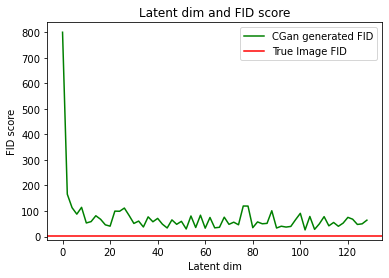

In [8]:
plt.plot(range(0,129,2), fid_scores,c = 'g' ,label = 'CGan generated FID')
plt.axhline(np.mean(fid_socre_between_true), color = 'r', label = 'True Image FID')
plt.title('Latent dim and FID score')
plt.xlabel('Latent dim')
plt.ylabel('FID score')
plt.legend()
plt.show()

In [6]:
# start running experiment
true_images = []
for img_batch in dataset:
    true_images.append(img_batch[0])
true_images = tf.concat(true_images, axis = 0)
true_images = preprocess_imgs(true_images[:10000]) # select 10000 imgs from calculating fid score

# load inception model
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))
# experiment for unconditional GAN
# to save experiment time, latent dim increased by 2
Uncond_fid_scores = []
for i in range(1,129):
    if i%2 == 0 or i==1:
        print('-'*60)
        print(f'current experiment latent dim: {i}')
        start_time = time.time()
        fid_score = run_a_experiment_with_uncond_GAN(i,inception_model,true_images)
        end_time = time.time()
        print(f'time used for whole experiment: {round(end_time-start_time,2)} seconds')
        print(f'current id score = {fid_score}')
        Uncond_fid_scores.append(fid_score)

------------------------------------------------------------
current experiment latent dim: 1
Time for training GAN model: 278.3 seconds
time used for whole experiment: 301.29 seconds
current id score = 501.271051503148
------------------------------------------------------------
current experiment latent dim: 2
Time for training GAN model: 275.49 seconds
time used for whole experiment: 296.97 seconds
current id score = 206.92308650834772
------------------------------------------------------------
current experiment latent dim: 4
Time for training GAN model: 282.59 seconds
time used for whole experiment: 303.17 seconds
current id score = 190.78455126350877
------------------------------------------------------------
current experiment latent dim: 6
Time for training GAN model: 423.94 seconds
time used for whole experiment: 447.25 seconds
current id score = 71.32215379965015
------------------------------------------------------------
current experiment latent dim: 8
Time for training 

Time for training GAN model: 269.58 seconds
time used for whole experiment: 288.83 seconds
current id score = 112.66186857935335
------------------------------------------------------------
current experiment latent dim: 76
Time for training GAN model: 260.25 seconds
time used for whole experiment: 278.98 seconds
current id score = 111.27976095133529
------------------------------------------------------------
current experiment latent dim: 78
Time for training GAN model: 258.62 seconds
time used for whole experiment: 277.73 seconds
current id score = 91.84538781189887
------------------------------------------------------------
current experiment latent dim: 80
Time for training GAN model: 258.92 seconds
time used for whole experiment: 277.71 seconds
current id score = 79.04473610751572
------------------------------------------------------------
current experiment latent dim: 82
Time for training GAN model: 258.8 seconds
time used for whole experiment: 277.68 seconds
current id score

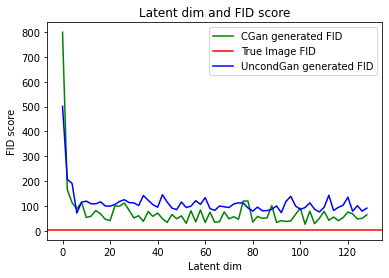

In [17]:
plt.plot(range(0,129,2), fid_scores,c = 'g' ,label = 'CGan generated FID')
plt.axhline(np.mean(fid_socre_between_true), color = 'r', label = 'True Image FID')
plt.plot(range(0,129,2),Uncond_fid_scores, color = 'b', label = 'UncondGan generated FID')
plt.title('Latent dim and FID score')
plt.xlabel('Latent dim')
plt.ylabel('FID score')
plt.legend()
plt.show()

In [20]:
# to save experiment time, latent dim increased by 2
fid_scores_before_20 = []
for i in range(0,20):
        print('-'*60)
        print(f'current experiment latent dim: {i}')
        start_time = time.time()
        fid_score = run_a_experiment_with_fixed_dim(i,inception_model,true_images)
        end_time = time.time()
        print(f'time used for whole experiment: {round(end_time-start_time,2)} seconds')
        print(f'current id score = {fid_score}')
        fid_scores_before_20.append(fid_score)

------------------------------------------------------------
current experiment latent dim: 0
Time for training GAN model: 329.33 seconds
time used for whole experiment: 350.28 seconds
current id score = 653.8850280780812
------------------------------------------------------------
current experiment latent dim: 1
Time for training GAN model: 334.45 seconds
time used for whole experiment: 356.37 seconds
current id score = 330.99759515779846
------------------------------------------------------------
current experiment latent dim: 2
Time for training GAN model: 334.48 seconds
time used for whole experiment: 354.36 seconds
current id score = 191.03662464500047
------------------------------------------------------------
current experiment latent dim: 3
Time for training GAN model: 332.51 seconds
time used for whole experiment: 351.65 seconds
current id score = 88.95467044400478
------------------------------------------------------------
current experiment latent dim: 4
Time for trainin

In [21]:
Uncond_fid_scores_before_20 = []
for i in range(1,20):
    print('-'*60)
    print(f'current experiment latent dim: {i}')
    start_time = time.time()
    fid_score = run_a_experiment_with_uncond_GAN(i,inception_model,true_images)
    end_time = time.time()
    print(f'time used for whole experiment: {round(end_time-start_time,2)} seconds')
    print(f'current id score = {fid_score}')
    Uncond_fid_scores_before_20.append(fid_score)

------------------------------------------------------------
current experiment latent dim: 1
Time for training GAN model: 254.2 seconds
time used for whole experiment: 273.72 seconds
current id score = 751.1722032493899
------------------------------------------------------------
current experiment latent dim: 2
Time for training GAN model: 253.75 seconds
time used for whole experiment: 272.51 seconds
current id score = 214.0923981614655
------------------------------------------------------------
current experiment latent dim: 3
Time for training GAN model: 252.58 seconds
time used for whole experiment: 271.46 seconds
current id score = 168.57476229497868
------------------------------------------------------------
current experiment latent dim: 4
Time for training GAN model: 252.8 seconds
time used for whole experiment: 271.76 seconds
current id score = 162.6246526068109
------------------------------------------------------------
current experiment latent dim: 5
Time for training G

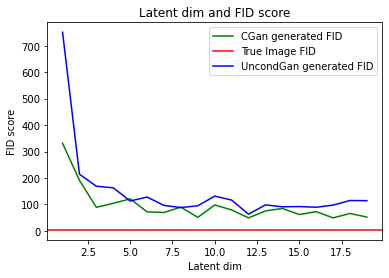

In [25]:
plt.plot(range(1,20),fid_scores_before_20[1:] ,c = 'g' ,label = 'CGan generated FID')
plt.axhline(np.mean(fid_socre_between_true), color = 'r', label = 'True Image FID')
plt.plot(range(1,20),Uncond_fid_scores_before_20, color = 'b', label = 'UncondGan generated FID')
plt.title('Latent dim and FID score')
plt.xlabel('Latent dim')
plt.ylabel('FID score')
plt.legend()
plt.show()

In [23]:
table = pd.DataFrame({
    'fid_score':fid_scores_before_20
})
table.to_csv('fid_list_20.csv')

In [24]:
table = pd.DataFrame({
    'fid_score':Uncond_fid_scores_before_20
})
table.to_csv('fid_list_UNCONDgan_20.csv')